# Streamflow pre-processing
This Notebook reads streamflow daily observations for a test river basin. From these data, it calculates streamflow volumes for specified target periods.

Decisions:
- We perform a linear interpolation of the daily streamflow data before calculating volumes, to fill in small data gap of maximum 15 days. See user-specified variables below.
- Volumes are calculated for the target periods: January-September, February-September, March-September, ..., September-September. The target periods start dates progressively approach the end of the water year, while the target periods end date is fixed to the end of the water year. See user-specified variables below.

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- The volumes calculation code assumes that the target periods don't overlap 2 different years.

## Modules, settings & functions

In [11]:
# Import required modules
import datetime
import logging
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import sys
import xarray as xr

In [12]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

%load_ext autoreload
%autoreload 2

2025-01-20 15:58:45,846 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE_PREVAH\logs\data_driven_forecasting_20250120_155845.log


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 2_StreamflowPreprocessing')

In [14]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2025-01-20 15:58:46,783 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../PREVAH/input_data/SWE_prevah_m3.nc',
 'basins_dem_path': '../PREVAH/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../PREVAH/input_data/ebene_40km_with_ids.shp',
 'domain': 'V947',
 'glacier_component_path': '../PREVAH/input_data/GL_prevah.nc',
 'output_data_path': '../PREVAH/output_data_glaciated/',
 'plots_path': '../PREVAH/output_plots_glaciated/',
 'precip_obs_path': '../PREVAH/input_data/P_prevah_m3.nc',
 'streamflow_obs_path': '../PREVAH/input_data/Q_prevah_m3.nc'}


## Variables

In [15]:
# Set user-specified variables
#test_basin_id = 'V457'  # Set basin_id for testing
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
max_gap_days_default = 15  # max. number of days for gaps in the daily streamflow data we perform linear interpolation for
target_periods = ['01/01-30/09','01/02-30/09','01/03-30/09','01/04-30/09','01/05-30/09','01/06-30/09','01/07-30/09','01/08-30/09','01/09-30/09']  # target periods for volume calculations, where each period is described as 'start_DD/start_MM-end_DD/end_MM'

In [16]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'linear interpolation maximum gap (days): {max_gap_days_default}')
logger.debug(f'flow accumulation target periods: {target_periods}')

## Read data

In [17]:
# Read the basin outlet's daily streamflow data as a DataArray 
Qobs_ds = xr.open_dataset(settings['streamflow_obs_path'])
Qobs_testbasin_da = Qobs_ds.where(Qobs_ds.Station_ID==test_basin_id, drop=True).Flow
Qobs_testbasin_da = Qobs_testbasin_da.set_index({"Station_ID":"Station_ID"})

display(Qobs_testbasin_da)

<xarray.DataArray 'Flow' (time: 15340, Station_ID: 1)>
array([[0.40266829],
       [0.39224322],
       [0.4417623 ],
       ...,
       [1.07378211],
       [0.92392174],
       [0.91610294]])
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
    lon         (Station_ID) float64 2.621e+06
    lat         (Station_ID) float64 1.118e+06
    area        (Station_ID) float64 1.126e+08
  * Station_ID  (Station_ID) object 'V947'

In [18]:
# read glacier component
GL_component_ds = xr.open_dataset(settings['glacier_component_path'])
GL_component_testbasin_da = GL_component_ds.where(GL_component_ds.Station_ID==test_basin_id, drop=True).gl_tot
display(GL_component_testbasin_da)

<xarray.DataArray 'gl_tot' (time: 15340, Station_ID: 1)>
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2022-12-31
  * Station_ID  (Station_ID) object 'V947'

In [19]:
# subtract glacier component
# Konvertiere Qobs_testbasin_da in ein Dataset
Qobs_testbasin_da = Qobs_testbasin_da.to_dataset(name="Flow")

# Subtraktion der Gletscherkomponente und Hinzufügen als neue Variable
Qobs_testbasin_da["flow_without_gl_component"] = (
    Qobs_testbasin_da["Flow"] - GL_component_testbasin_da
)

# Überprüfung des Ergebnisses
display(Qobs_testbasin_da)


<xarray.Dataset>
Dimensions:                    (Station_ID: 1, time: 15340)
Coordinates:
  * time                       (time) datetime64[ns] 1981-01-01 ... 2022-12-31
    lon                        (Station_ID) float64 2.621e+06
    lat                        (Station_ID) float64 1.118e+06
    area                       (Station_ID) float64 1.126e+08
  * Station_ID                 (Station_ID) object 'V947'
Data variables:
    Flow                       (time, Station_ID) float64 0.4027 ... 0.9161
    flow_without_gl_component  (time, Station_ID) float64 0.4027 ... 0.9161

In [20]:
"""
# Filtere die Daten für das Jahr 2016
flow_2016 = Qobs_testbasin_da["Flow"].sel(time=slice("2016-01-01", "2016-12-31")).squeeze()
flow_without_gl_2016 = Qobs_testbasin_da["flow_without_gl_component"].sel(time=slice("2016-01-01", "2016-12-31")).squeeze()

# Überprüfen der Dimensionen des DataArrays
print(flow_without_gl_2016.dims)

# Sicherstellen, dass flow_without_gl_2016 auf "time" reduziert wird
if "nday" in flow_without_gl_2016.dims:
    flow_without_gl_2016 = flow_without_gl_2016.mean(dim="nday", skipna=True)

# Plotten der Daten
plt.figure(figsize=(12, 6))
plt.plot(flow_2016["time"], flow_2016, label="Flow", color="blue")
plt.plot(flow_without_gl_2016["time"], flow_without_gl_2016, label="Flow Without Glacier Component", color="orange")

# Achsenbeschriftung und Titel
plt.xlabel("Date")
plt.ylabel("Flow (m³/s)")
plt.title("Flow and Flow Without Glacier Component (2016)")
plt.legend()
plt.grid(True)

# Plot anzeigen
plt.show()
"""

'\n# Filtere die Daten für das Jahr 2016\nflow_2016 = Qobs_testbasin_da["Flow"].sel(time=slice("2016-01-01", "2016-12-31")).squeeze()\nflow_without_gl_2016 = Qobs_testbasin_da["flow_without_gl_component"].sel(time=slice("2016-01-01", "2016-12-31")).squeeze()\n\n# Überprüfen der Dimensionen des DataArrays\nprint(flow_without_gl_2016.dims)\n\n# Sicherstellen, dass flow_without_gl_2016 auf "time" reduziert wird\nif "nday" in flow_without_gl_2016.dims:\n    flow_without_gl_2016 = flow_without_gl_2016.mean(dim="nday", skipna=True)\n\n# Plotten der Daten\nplt.figure(figsize=(12, 6))\nplt.plot(flow_2016["time"], flow_2016, label="Flow", color="blue")\nplt.plot(flow_without_gl_2016["time"], flow_without_gl_2016, label="Flow Without Glacier Component", color="orange")\n\n# Achsenbeschriftung und Titel\nplt.xlabel("Date")\nplt.ylabel("Flow (m³/s)")\nplt.title("Flow and Flow Without Glacier Component (2016)")\nplt.legend()\nplt.grid(True)\n\n# Plot anzeigen\nplt.show()\n'

<IPython.core.display.Javascript object>


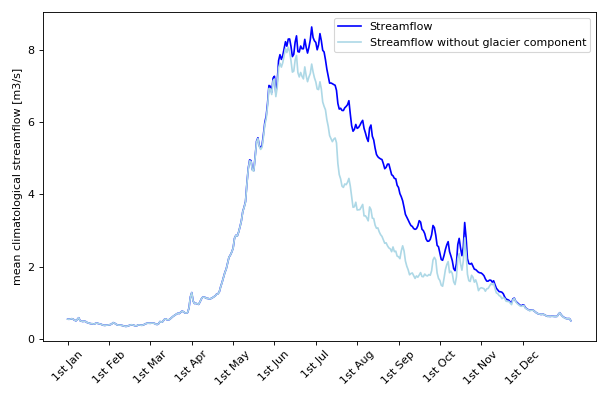

In [21]:
fig = plt.figure(figsize=(7.6, 5))
streamflow_data_da = Qobs_testbasin_da.Flow
streamflow_without_gl = Qobs_testbasin_da["flow_without_gl_component"]
doy_mean_1 = streamflow_data_da.groupby("time.dayofyear").mean(skipna=True)
doy_mean_2 = streamflow_without_gl.groupby("time.dayofyear").mean(skipna=True)
plt.plot(np.arange(366), doy_mean_1.values, color='b', label= "Streamflow")
plt.plot(np.arange(366), doy_mean_2.values, color='lightblue', label= "Streamflow without glacier component")
plt.legend(loc="upper right")
plt.ylabel('mean climatological streamflow [m3/s]')
plt.xticks(np.arange(0,360,30),['1st Jan', '1st Feb', '1st Mar', '1st Apr', '1st May', '1st Jun', '1st Jul', '1st Aug', '1st Sep', '1st Oct', '1st Nov', '1st Dec'], rotation=45)
plt.tight_layout();

In [22]:
# Save the figure
fig.savefig(settings['plots_path']+"hydrograph_comparison"+test_basin_id+".png", dpi=300)

<IPython.core.display.Javascript object>


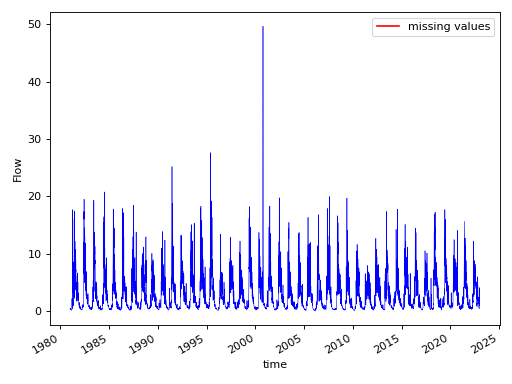

In [27]:
# Plot the basin's daily streamflow data and identify missing data
fig = plt.figure()
Qobs_testbasin_da["Flow"].plot(lw=.5, color='b')
missing_values = Qobs_testbasin_da["Flow"].fillna(-1)
missing_values = missing_values.where(missing_values==-1)
missing_values.plot(color='r', label='missing values')
plt.legend()
plt.title('')
plt.tight_layout();

In [28]:
# Save the figure
fig.savefig(settings['plots_path']+"daily_Qobs_basin"+test_basin_id+".png", dpi=300)

In [29]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Calculate flow volumes
Here, we calculate flow volumes. In other words, we accumulate daily streamflow values over specified target periods. Note that no volume is saved if there is at least one missing daily streamflow value. To maximize the amount of data, we first run a linear interpolation.

In [30]:
# Perform linear interpolation to fill in small data gaps
interpolated_data = Qobs_testbasin_da["flow_without_gl_component"].interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=max_gap_days_default))
interpolated_data_2 = Qobs_testbasin_da["Flow"].interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=max_gap_days_default))

In [32]:
# Calculate volumes

# loop over target periods
for p in target_periods:

    # define period for which to calculate volumes
    start_day = int(p[0:2])
    start_month = int(p[3:5])
    end_day = int(p[6:8])
    end_month = int(p[9:11])
    start_month_name = datetime.datetime.strptime(str(start_month), "%m").strftime("%b")
    end_month_name = datetime.datetime.strptime(str(end_month), "%m").strftime("%b")

    # calculate volumes for all years' target periods with no missing data
    # for period within the same calendar year
    if start_month <= end_month:
        volumes_period = interpolated_data.sel(time=( ((interpolated_data['time.month'] == start_month) & (interpolated_data['time.day'] >= start_day)) | ((interpolated_data['time.month'] == end_month) & (interpolated_data['time.day'] <= end_day)) | ((interpolated_data['time.month'] > start_month) & (interpolated_data['time.month'] < end_month)) ))
    # for period in 2 calendar years (e.g., 1 December to 31 January)
    elif start_month > end_month:
        volumes_period = interpolated_data.sel(time=( ((interpolated_data['time.month'] == start_month) & (interpolated_data['time.day'] >= start_day)) | ((interpolated_data['time.month'] == end_month) & (interpolated_data['time.day'] <= end_day)) | (interpolated_data['time.month'] > start_month) | (interpolated_data['time.month'] < end_month) ))
    volumes_da = volumes_period.groupby("time.year").sum("time", skipna=False) * 86400

    # save to xarray Dataset
    volumes_da.attrs['long_name'] = 'Volumes'
    volumes_da.attrs['info'] = 'Calculated over time period: '+p
    volumes_da.attrs['units'] = 'm3'
    volumes_da = volumes_da.rename('Vol_'+str(start_day)+start_month_name+'-'+str(end_day)+end_month_name)
    if p == target_periods[0]:
        volumes_testbasin_ds = volumes_da
    else:
        volumes_testbasin_ds = xr.merge([volumes_testbasin_ds,volumes_da])

display(volumes_testbasin_ds)

<xarray.Dataset>
Dimensions:         (Station_ID: 1, year: 42)
Coordinates:
    lon             (Station_ID) float64 2.621e+06
    lat             (Station_ID) float64 1.118e+06
    area            (Station_ID) float64 1.126e+08
  * Station_ID      (Station_ID) object 'V947'
  * year            (year) int64 1981 1982 1983 1984 ... 2019 2020 2021 2022
Data variables:
    Vol_1Jan-30Sep  (year, Station_ID) float64 8.162e+07 9.538e+07 ... 8.705e+06
    Vol_1Feb-30Sep  (year, Station_ID) float64 8.078e+07 9.403e+07 ... 6.339e+06
    Vol_1Mar-30Sep  (year, Station_ID) float64 8.032e+07 9.326e+07 ... 5.157e+06
    Vol_1Apr-30Sep  (year, Station_ID) float64 7.711e+07 9.246e+07 ... 4.034e+06
    Vol_1May-30Sep  (year, Station_ID) float64 6.815e+07 9.065e+07 ... 3.235e+05
    Vol_1Jun-30Sep  (year, Station_ID) float64 5.865e+07 ... -1.427e+07
    Vol_1Jul-30Sep  (year, Station_ID) float64 3.533e+07 ... -1.425e+07
    Vol_1Aug-30Sep  (year, Station_ID) float64 1.797e+07 ... -7.066e+06
    Vol_1Sep-30Sep  (year, Station_ID) float64 6.744e+06 ... -9.218e+05

In [33]:
# Calculate volumes

# loop over target periods
for p in target_periods:

    # define period for which to calculate volumes
    start_day = int(p[0:2])
    start_month = int(p[3:5])
    end_day = int(p[6:8])
    end_month = int(p[9:11])
    start_month_name = datetime.datetime.strptime(str(start_month), "%m").strftime("%b")
    end_month_name = datetime.datetime.strptime(str(end_month), "%m").strftime("%b")

    # calculate volumes for all years' target periods with no missing data
    # for period within the same calendar year
    if start_month <= end_month:
        volumes_period = interpolated_data_2.sel(time=( ((interpolated_data_2['time.month'] == start_month) & (interpolated_data_2['time.day'] >= start_day)) | ((interpolated_data_2['time.month'] == end_month) & (interpolated_data_2['time.day'] <= end_day)) | ((interpolated_data_2['time.month'] > start_month) & (interpolated_data_2['time.month'] < end_month)) ))
    # for period in 2 calendar years (e.g., 1 December to 31 January)
    elif start_month > end_month:
        volumes_period = interpolated_data_2.sel(time=( ((interpolated_data_2['time.month'] == start_month) & (interpolated_data_2['time.day'] >= start_day)) | ((interpolated_data_2['time.month'] == end_month) & (interpolated_data_2['time.day'] <= end_day)) | (interpolated_data_2['time.month'] > start_month) | (interpolated_data_2['time.month'] < end_month) ))
    volumes_da = volumes_period.groupby("time.year").sum("time", skipna=False) * 86400

    # save to xarray Dataset
    volumes_da.attrs['long_name'] = 'Volumes'
    volumes_da.attrs['info'] = 'Calculated over time period: '+p
    volumes_da.attrs['units'] = 'm3'
    volumes_da = volumes_da.rename('Vol_'+str(start_day)+start_month_name+'-'+str(end_day)+end_month_name)
    if p == target_periods[0]:
        volumes_testbasin_original = volumes_da
    else:
        volumes_testbasin_original = xr.merge([volumes_testbasin_original,volumes_da])

display(volumes_testbasin_original)

<xarray.Dataset>
Dimensions:         (Station_ID: 1, year: 42)
Coordinates:
    lon             (Station_ID) float64 2.621e+06
    lat             (Station_ID) float64 1.118e+06
    area            (Station_ID) float64 1.126e+08
  * Station_ID      (Station_ID) object 'V947'
  * year            (year) int64 1981 1982 1983 1984 ... 2019 2020 2021 2022
Data variables:
    Vol_1Jan-30Sep  (year, Station_ID) float64 8.431e+07 9.776e+07 ... 7.782e+07
    Vol_1Feb-30Sep  (year, Station_ID) float64 8.347e+07 9.641e+07 ... 7.546e+07
    Vol_1Mar-30Sep  (year, Station_ID) float64 8.301e+07 9.564e+07 ... 7.427e+07
    Vol_1Apr-30Sep  (year, Station_ID) float64 7.979e+07 9.484e+07 ... 7.315e+07
    Vol_1May-30Sep  (year, Station_ID) float64 7.084e+07 9.302e+07 ... 6.944e+07
    Vol_1Jun-30Sep  (year, Station_ID) float64 6.133e+07 7.836e+07 ... 5.351e+07
    Vol_1Jul-30Sep  (year, Station_ID) float64 3.771e+07 4.654e+07 ... 3.789e+07
    Vol_1Aug-30Sep  (year, Station_ID) float64 1.978e+07 2.435e+07 ... 1.996e+07
    Vol_1Sep-30Sep  (year, Station_ID) float64 7.63e+06 9.429e+06 ... 6.142e+06

In [34]:
"""
# Plot output volumes for a specific target period to see what they look like
volumes_testbasin_ds['Vol_1Jan-30Sep'].plot(color='b', marker='o', lw=.1)
plt.title('')
plt.tight_layout();
"""

"\n# Plot output volumes for a specific target period to see what they look like\nvolumes_testbasin_ds['Vol_1Jan-30Sep'].plot(color='b', marker='o', lw=.1)\nplt.title('')\nplt.tight_layout();\n"

<IPython.core.display.Javascript object>


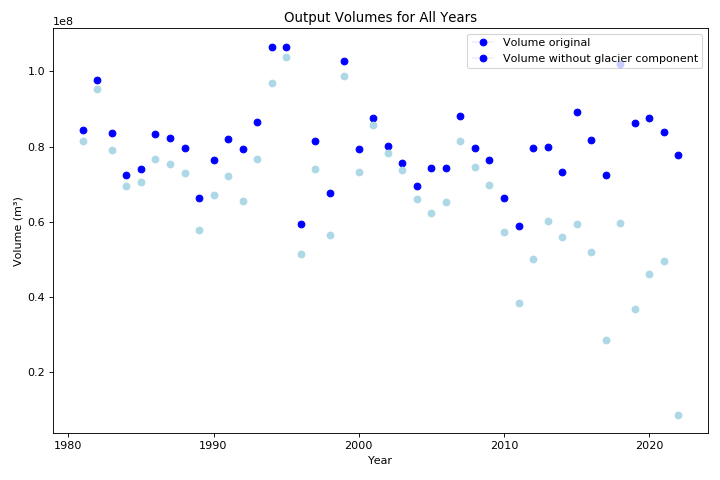

In [41]:
import matplotlib.pyplot as plt

# Erstelle eine neue Figur
plt.figure(figsize=(9, 6))


 # Iteriere über jedes Jahr und füge die Daten zum Plot hinzu
for i, year in enumerate(volumes_testbasin_original["year"].values):
    data_for_year = volumes_testbasin_original["Vol_1Jan-30Sep"].sel(year=year)
    plt.plot([year], data_for_year, marker='o', color = 'b', lw=.1, label=f'Year {year}' if i == 0 else "")

# Iteriere über jedes Jahr und füge die Daten zum Plot hinzu
for i, year in enumerate(volumes_testbasin_ds["year"].values):
    data_for_year = volumes_testbasin_ds["Vol_1Jan-30Sep"].sel(year=year)
    plt.plot([year], data_for_year, marker='o', color = 'lightblue', lw=.1, label=f'Year {year}' if i == 0 else "")  # Einmaliges Label


# Plot-Details anpassen
plt.title('Output Volumes for All Years')
plt.xlabel('Year')
plt.ylabel('Volume (m³)')
plt.legend(['Volume original','Volume without glacier component'], loc='upper right')  # Kombiniertes Label
plt.tight_layout()
plt.show()


## Save data
Save the output volumes so we can read them in other Notebooks.

In [42]:
# Save the data
volumes_testbasin_ds.to_netcdf(settings['output_data_path']+"Vol_1979_2021_basin"+test_basin_id+".nc", format="NETCDF4")
volumes_testbasin_original.to_netcdf(settings['output_data_path']+"Vol_1979_2021_basin_original"+test_basin_id+".nc", format="NETCDF4")